In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD,Adam

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
import os
import tensorflow as tf
plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
valid_dir="../input/expression-dataset/dataset/validation"
train_dir="../input/expression-dataset/dataset/training"

train_dir_good = train_dir + '/good'
train_dir_bad = train_dir + '/bad'
valid_dir_good = valid_dir + '/good'
valid_dir_bad = valid_dir + '/bad'

NameError: name 'test_dir' is not defined

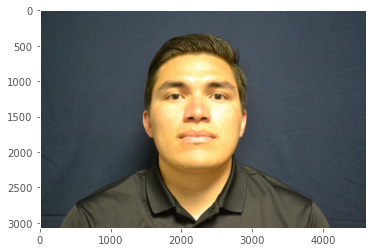

In [4]:
EXAMPLE_PIC = train_dir_good + '/100_indifferent.jpg'
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)

In [5]:
print('number of bad training images - ',len(os.listdir(train_dir_bad)))
print('number of good training images - ',len(os.listdir(train_dir_good)))
print('number of bad validation images - ',len(os.listdir(valid_dir_bad)))
print('number of good validation images - ',len(os.listdir(valid_dir_good)))

number of bad training images -  204
number of good training images -  202


NameError: name 'valid_dir_bad' is not defined

In [7]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
validation_datagen= ImageDataGenerator(rescale = 1./255)

In [8]:
batch_size = 32
training_data = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (256,256),
                                                   batch_size = batch_size,
                                                   class_mode = 'binary')
validation_data = validation_datagen.flow_from_directory(directory = valid_dir,
                                                  target_size = (256,256),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary')

Found 406 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(256,256, 3))

print("number of layers:", len(inc_model.layers))
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
model_v3= Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_v3.layers[:52]:
    layer.trainable = False

# compile the model
model_v3.compile(optimizer=Adam()
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])
model_v3.summary()

87916544/87910968 [==============================] - 2s 0us/step
number of layers: 311
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______

In [10]:
# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = training_data.image_shape))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(rate = 0.3))
# model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(rate = 0.2))
# model.add(Conv2D(filters = 126, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(rate = 0.15))
# model.add(Flatten())
# model.add(Dense(units = 32, activation = 'relu'))
# model.add(Dropout(rate = 0.15))
# model.add(Dense(units = 64, activation = 'relu'))
# model.add(Dropout(rate = 0.1))
# model.add(Dense(units = 1, activation = 'sigmoid'))
# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
# model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 60, 60, 126)       7

In [37]:
# fitted_model = model.fit_generator(training_data,
#                         steps_per_epoch = 406/batch_size,
#                         epochs = 10,
#                         validation_data = testing_data,
#                         verbose=1)

Epoch 1/10
13/12 [==============================] - 233s 18s/step - loss: 0.7037 - accuracy: 0.4729 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/10
13/12 [==============================] - 233s 18s/step - loss: 0.6966 - accuracy: 0.4852 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
13/12 [==============================] - 233s 18s/step - loss: 0.6931 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
13/12 [==============================] - 232s 18s/step - loss: 0.6935 - accuracy: 0.4926 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
13/12 [==============================] - 233s 18s/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
13/12 [==============================] - 232s 18s/step - loss: 0.6933 - accuracy: 0.4828 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
13/12 [==============================] - 253s 19s/step - loss: 0.6934 - accuracy: 0.4926 - val_loss: 0.6931 - val_accuracy: 0.4250
Epoch 

In [11]:
hist = model_v3.fit_generator(training_data,
                              validation_data = validation_data, 
                              steps_per_epoch= 406/batch_size,
                              epochs= 10,
                              verbose=1)

Epoch 1/10
13/12 [==============================] - 244s 19s/step - loss: 0.8346 - accuracy: 0.4951 - val_loss: 1580.6398 - val_accuracy: 0.5000
Epoch 2/10
13/12 [==============================] - 243s 19s/step - loss: 0.7151 - accuracy: 0.5025 - val_loss: 3830.1492 - val_accuracy: 0.5000
Epoch 3/10
13/12 [==============================] - 237s 18s/step - loss: 0.6998 - accuracy: 0.5640 - val_loss: 38.9140 - val_accuracy: 0.5000
Epoch 4/10
13/12 [==============================] - 237s 18s/step - loss: 0.7131 - accuracy: 0.5394 - val_loss: 1205.4465 - val_accuracy: 0.5000
Epoch 5/10
13/12 [==============================] - 238s 18s/step - loss: 0.5440 - accuracy: 0.7586 - val_loss: 22.4145 - val_accuracy: 0.5000
Epoch 6/10
13/12 [==============================] - 239s 18s/step - loss: 0.3558 - accuracy: 0.8596 - val_loss: 6.4740 - val_accuracy: 0.5000
Epoch 7/10
13/12 [==============================] - 240s 18s/step - loss: 0.2643 - accuracy: 0.8941 - val_loss: 9997.0469 - val_accuracy:

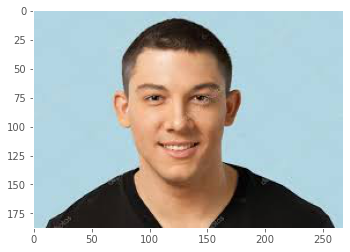

In [15]:
test_dir="../input/test-set/test/"
test_eg= test_dir + '2Q__ (3).jpg'
img = load_img(test_eg)
plt.grid(False)
plt.imshow(img)


In [16]:
def show(test):
    img = load_img(test)
    plt.grid(False)
    plt.imshow(img)

In [19]:
test_dir="../input/test-set/test/"
def testing_image(image_directory):
    img = load_img(image_directory)
    plt.grid(False)
    plt.imshow(img)
    test_image = load_img(image_directory, target_size = (64, 64))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_v3.predict(x = test_image)
    print(result)
    if result[0][0]  == 1:
        prediction = 'Bad'
    else:
        prediction = 'Good'
    return prediction

In [21]:
# testing_image(test_dir + '2Q__ (3).jpg')

[[0.7318351]]


'Good'

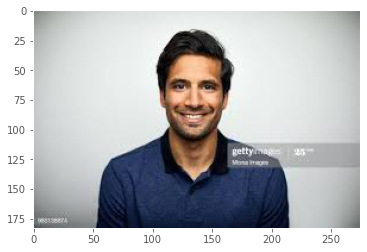

In [70]:
testing_image(test_dir + 'Z (10).jpg')

[[0.70676404]]


'Good'

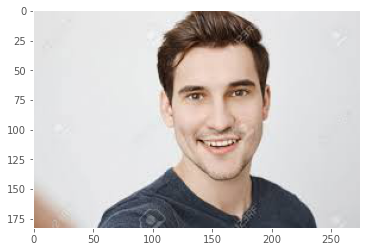

In [60]:
testing_image(test_dir + '2Q__ (4).jpg')

[[0.7150073]]


'Good'

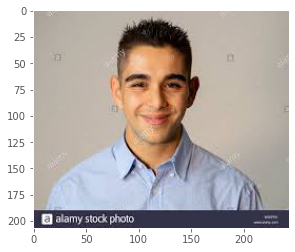

In [61]:
testing_image(test_dir + '2Q__ (6).jpg')

[[0.767614]]


'Good'

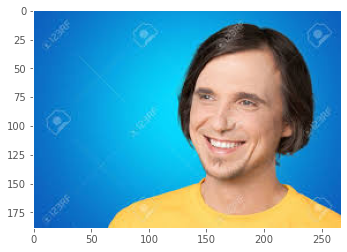

In [62]:
testing_image(test_dir + 'Z (11).jpg')

[[0.69012356]]


'Good'

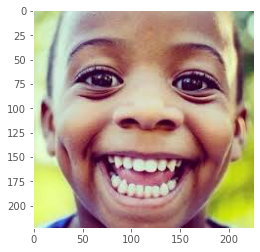

In [63]:
testing_image(test_dir + 'Z (6).jpg')

[[0.6997038]]


'Good'

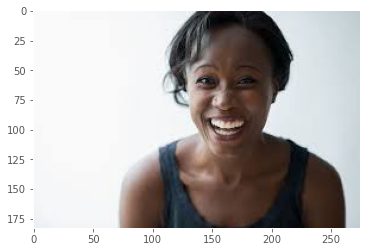

In [64]:
testing_image(test_dir + 'Z (8).jpg')

[[0.71296966]]


'Good'

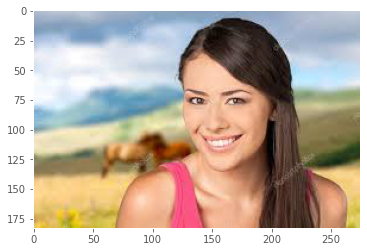

In [65]:
testing_image(test_dir + 'Z (9).jpg')

In [12]:
# for i in range(1,15):
#     testing_image(dire + 'images ({}).jpg'.format(i))
#     show(dire + 'images ({}).jpg'.format(i))

In [13]:
# show(dire + 'images ({}).jpg'.format(5))